# Testing Shor's 3 Qubit Code ($X_{err}$)

Test error correction tecniques on [Qibo](https://qibo.science/qibo/stable/index.html) library

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')    # Use dark background for plots

import qibo
assert qibo.__version__ >= "0.2.20", "This script requires qibo version 0.2.20 or higher."

from qibo import Circuit, gates
from qibo.gates import *

from qibo.ui import plot_circuit, plot_density_hist, visualize_state


custom_style = {                    # Define a custom style for the circuit plot
    "facecolor" : "#000000",
    "edgecolor" : "#ffffff",
    "linecolor" : "#ffffff",
    "textcolor" : "#ffffff",
    "fillcolor" : "#c41b1b",
    "gatecolor" : "#9000ff",
    "controlcolor" : "#360000"
}

We can define the *logical* qubit as a particular state of the system:

$\ket{0}_L = \ket{000}$

$\ket{1}_L = \ket{111}$

Stybilizers are observables that maintain the logical qubit unvaried after a measurement:

$S_1 = Z_1Z_2$

$S_2 = Z_2Z_3$

$S_1 \ket{0}_L = \ket{0}_L$

## How do we measure the stabilizers?

In [15]:
def ZZ_measurement(circuit:Circuit, control_1:int, control_2:int, target:int):
    """Adds a ZZ stabilizer measurement to the circuit."""

    circuit.add(H(target))
    circuit.add(CZ(control_1, target))
    circuit.add(CZ(control_2, target))
    circuit.add(H(target))
    
    return circuit

Let's visualize the stabilizer measurement circuit

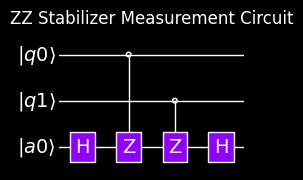

In [16]:
circuit = Circuit(3, wire_names=['q0', 'q1', 'a0'])  # 2 data qubits + 1 ancilla qubit

ZZ_measurement(circuit, 0, 1, 2)  # Measure Z0Z1 stabilizer

plot_circuit(circuit, style=custom_style)  # Plot the circuit with custom style
plt.title("ZZ Stabilizer Measurement Circuit", color='white')
plt.show()

### Test with errors

In [17]:
for i in [0, 1, 2]:

    circuit = Circuit(3, wire_names=['q0', 'q1', 'a0'])  # 3 data qubits + 2 ancilla qubits

    circuit.add(X(i))  # Introduce an X error on qubit i
    
    ZZ_measurement(circuit, 0, 1, 2)  # Measure Z0Z1

    circuit.add(M(2, register_name='Z0Z1'))  # Measure ancilla qubit

    res = circuit(nshots=1000)

    print(f"Error on qubit {i}, Stabilizer measurements: {res.frequencies(registers=True)}")


Error on qubit 0, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000})}
Error on qubit 1, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000})}
Error on qubit 2, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000})}


### Conclusion:
The ancilla registers a change in the system! But it's clear that a single Stabilizer can't give enough information to indentify the error position in the register.

## Complete Error Detection With Both Stabilizers

Text(0.5, 1.0, '3-Qubit Shor Code X Error Detection Circuit')

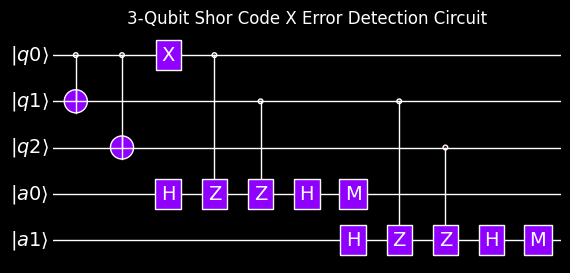

In [18]:
def shor_3_qubit_X_err(err_pos:int=0) -> Circuit:
    
    circuit = Circuit(5, wire_names=['q0', 'q1', 'q2', 'a0', 'a1'])
    
    circuit.add(CNOT(0, 1))
    circuit.add(CNOT(0, 2))

    circuit.add(X(err_pos))

    ZZ_measurement(circuit, 0, 1, 3)        # Measure Z0Z1
    circuit.add(M(3, register_name='Z0Z1'))

    ZZ_measurement(circuit, 1, 2, 4)        # Measure Z1Z2
    circuit.add(M(4, register_name='Z1Z2'))

    return circuit


plot_circuit(shor_3_qubit_X_err(), style=custom_style, cluster_gates = True)  # Plot the circuit with custom style
plt.title("3-Qubit Shor Code X Error Detection Circuit", color='white')

## Simulate

In [19]:
for i in [0, 1, 2]:

    circ = shor_3_qubit_X_err(err_pos=i)

    res = circ(nshots=1000)

    print(f"Error on qubit {i}, Stabilizer measurements: {res.frequencies(registers=True)}")

Error on qubit 0, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000}), 'Z1Z2': Counter({'0': 1000})}
Error on qubit 1, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000}), 'Z1Z2': Counter({'1': 1000})}
Error on qubit 2, Stabilizer measurements: {'Z0Z1': Counter({'0': 1000}), 'Z1Z2': Counter({'1': 1000})}


### Conclusion:

We can safely identify the position of the error!

We can even create a table for decyphering the error position. 
If we define measurement **'0'** as parity **+1** and measurement **'1'** as parity **-1** we get the following table:

| Pauli Error | $S_1$ = Z₁Z₂ | $S_2$ = Z₂Z₃ |
|------------------------|------------|------------|
| No Error               | +1         | +1         |
| $X_0$                     | -1         | +1         |
| $X_1$                   | -1         | -1         |
| $X_2$                     | +1         | -1         |


# Implementation of Logical Gates

A Logical Gate must maintain the structure of the original gate:

$H\ket{0} = \ket{0} + \ket{1}$

$H_L \ket{0}_L = \ket{0}_L + \ket{1}_L$

$X_L \ket{0}_L = \ket{1}_L$

In [ ]:
def logical_gate_H(circuit:Circuit, logical_qubit_indices:list[int]) -> Circuit:
    """Applies a logical Hadamard gate to the specified logical qubits."""
    
    for q in logical_qubit_indices:
        circuit.add(H(q))
    
    return circuit

In [48]:
def logical_gate_X(circuit:Circuit, logical_qubit_indices:list[int]) -> Circuit:
    """Applies a logical Hadamard gate to the specified logical qubits."""
    
    for q in logical_qubit_indices:
        circuit.add(X(q))
    
    return circuit

Plot Logical Qubit with its Gate

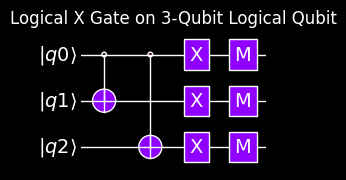

In [55]:
circuit = Circuit(3, wire_names=['q0', 'q1', 'q2'])  # 3 data qubits

# codify the logical qubit

circuit.add(CNOT(0, 1))
circuit.add(CNOT(0, 2))

logical_gate_X(circuit, [0, 1, 2])  # Apply logical Hadamard gate to all qubits

circuit.add(M(0,1,2))

plot_circuit(circuit, style=custom_style)  # Plot the circuit with custom style
plt.title("Logical X Gate on 3-Qubit Logical Qubit", color='white')
plt.show()

Measurements:

Logical Hadamard Gate, Measurement results: Counter({'111': 1000})


(<Axes: xlabel='States', ylabel='Probabilities'>,
 <Figure size 600x500 with 1 Axes>)

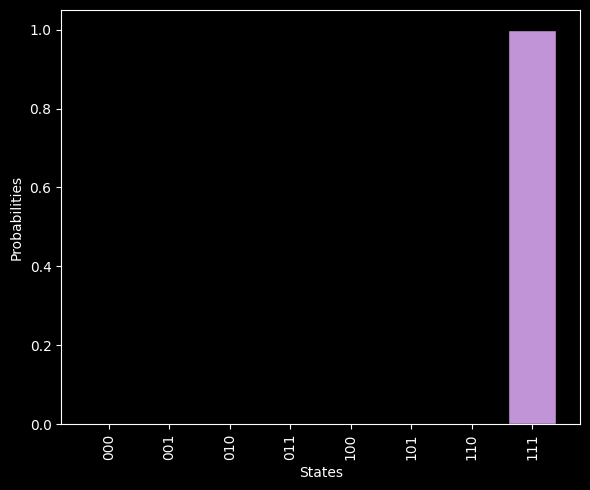

In [50]:
res = circuit(nshots=1000)
print(f"Logical Hadamard Gate, Measurement results: {res.frequencies()}")
visualize_state(res)

The results are correct!

Text(0.5, 1.0, '3-Qubit Shor Code X Error Detection Circuit')

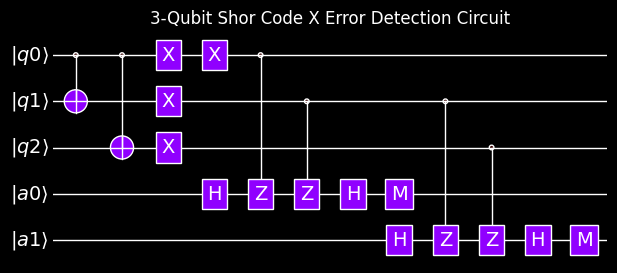

In [56]:
def Logical_Qubit_Shor_3(err_pos:int=0, logical_gate=None) -> Circuit:
    
    circuit = Circuit(5, wire_names=['q0', 'q1', 'q2', 'a0', 'a1'])
    
    circuit.add(CNOT(0, 1))
    circuit.add(CNOT(0, 2))

    if logical_gate is not None:
        logical_gate(circuit, [0, 1, 2])

    circuit.add(X(err_pos))

    ZZ_measurement(circuit, 0, 1, 3)        # Measure Z0Z1
    circuit.add(M(3, register_name='Z0Z1'))

    ZZ_measurement(circuit, 1, 2, 4)        # Measure Z1Z2
    circuit.add(M(4, register_name='Z1Z2'))

    return circuit

plot_circuit(Logical_Qubit_Shor_3(logical_gate=logical_gate_X), style=custom_style, cluster_gates = True)  # Plot the circuit with custom style
plt.title("3-Qubit Shor Code X Error Detection Circuit", color='white')

In [57]:
for i in [0, 1, 2]:

    circ = Logical_Qubit_Shor_3(logical_gate=logical_gate_X, err_pos=i)

    res = circ(nshots=1000)

    print(f"Error on qubit {i}, Stabilizer measurements: {res.frequencies(registers=True)}")

Error on qubit 0, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000}), 'Z1Z2': Counter({'0': 1000})}
Error on qubit 1, Stabilizer measurements: {'Z0Z1': Counter({'1': 1000}), 'Z1Z2': Counter({'1': 1000})}
Error on qubit 2, Stabilizer measurements: {'Z0Z1': Counter({'0': 1000}), 'Z1Z2': Counter({'1': 1000})}


We are still able to identify the position of the error! 

**Thus the code works with the implementation of logical gates too**